# Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

### Imports

In [1]:
import pandas as pd; import seaborn as sb; import warnings; import scipy; import re; 
import os; from analysis_helpers import *; import itertools; from scipy import stats
import random; import pandas as pd; import numpy as np; from sklearn import datasets, linear_model; 
from sklearn.linear_model import LinearRegression; import statsmodels.api as sm
from scipy import stats; from itertools import groupby; from operator import itemgetter; import pingouin
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Behavioral Data

In [2]:
# data = pd.read_csv('../parsed_data/FULL_DATA.csv')
data = pd.read_csv('../parsed_data/full_behavioral.csv')

data['Uncued Face'] = data['Uncued Composite'].str.split('_', n=1, expand=True)[0]+'.jpg'
data['Uncued Place'] = data['Uncued Composite'].str.split('_', n=1, expand=True)[1]
data['Cued Face'] = data['Cued Composite'].str.split('_', n=1, expand=True)[0]+'.jpg'
data['Cued Place'] = data['Cued Composite'].str.split('_', n=1, expand=True)[1]

## Organize Behavioral

### Add cued category from last presentation trial to memory blocks

In [3]:
# for each memory trial, add which category was last cued before that memory trial began

for s in data['UniqueID'].unique():
    for r in data['Run'].unique():
        data.loc[(data['Run']==r) 
                 & (data['UniqueID']==s) 
                 & (data['Trial Type']=='Memory'), 'Last Cued'] = data[(data['Run']==r) & (data['UniqueID']==s) & (data['Trial Type']=='Presentation') & (data['Trial']==9)]['Cued Category'].item()
        
# make a copy of the data where novel images labeled by whether they are in the last-cued image category

data_nov = data
data     = add_nov_label(data, column_name = 'Last Cued')

Participant with UniqueID 81 did not respond to the last six presentation trials in presentation Run 4 and may not have seen these images (see compile_data.ipynb). As such, the familiarity ratings for the images from these trials presented during the memory run are not included in the analyses. Here, we remove them before conducting our analysis.

In [4]:
cued_face_81_4    = list(data[(data['Attention Button']!=1.0)&(data['Attention Button']!=3.0)&(data['Trial Type']=='Presentation')]['Cued Face'])#['Attention Button']
cued_place_81_4   = list(data[(data['Attention Button']!=1.0)&(data['Attention Button']!=3.0)&(data['Trial Type']=='Presentation')]['Cued Place'])#['Attention Button']
uncued_face_81_4  = list(data[(data['Attention Button']!=1.0)&(data['Attention Button']!=3.0)&(data['Trial Type']=='Presentation')]['Uncued Face'])#['Attention Button']
uncued_place_81_4 = list(data[(data['Attention Button']!=1.0)&(data['Attention Button']!=3.0)&(data['Trial Type']=='Presentation')]['Uncued Place'])

In [5]:
missed_images = cued_face_81_4 + cued_place_81_4 + uncued_face_81_4 + uncued_place_81_4
run_4_mem = data[(data['UniqueID']==81) & (data['Trial Type']=='Memory')&(data['Run']==4)]

drop_index = run_4_mem.loc[run_4_mem['Memory Image'].isin(missed_images)].index

data = data.drop(drop_index)

# Statistics

Below are all of the statistical tests done on the behavioral data, roughly in the order they appear in the paper

### Reaction Time Stats (Cued vs. Uncued side)

In [6]:
# make sure sides are corrected exp2 group1

In [7]:
# compare average attention probe reaction times (valid versus invalid)

data_gr = data.groupby(['UniqueID','Cue Validity', 'Experiment', 'Group'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        dat = data_gr[(data_gr['Experiment']== experiment) & (data_gr['Group']== group)]
    
        print('exp : '+ experiment + ', group : '+str(group))
        print(scipy.stats.ttest_rel(dat[dat['Cue Validity']==1]['Attention Reaction Time (s)'], 
                                    dat[dat['Cue Validity']==0]['Attention Reaction Time (s)']))

        print()
        
#         print(cohen_d(list(data_gr[(data_gr['Cue Validity']==1) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)']),
#                       list(data_gr[(data_gr['Cue Validity']==0) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)'])))

        print()

exp : /sustain, group : 1
Ttest_relResult(statistic=-2.7265644956566235, pvalue=0.01074400669470906)


exp : /sustain, group : 2
Ttest_relResult(statistic=0.9444743107662367, pvalue=0.3527303287974207)


exp : /variabl, group : 1
Ttest_relResult(statistic=-0.5318760704045474, pvalue=0.5988631588943483)


exp : /variabl, group : 2
Ttest_relResult(statistic=-0.3636086666417915, pvalue=0.7196210791011965)




# Calculate Differences

In [8]:
# make empty dictionary, diffs
diffs = {}

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment+str(group)
    
        # make a key in the diffs dictionary for this experiment
        diffs[label] = []

        # select the data for this experiment only
        d = data_gr[(data_gr['Experiment']== experiment) & (data_gr['Group']==group)]

        # for each participant in the experiment
        for s in d['Subject'].unique():

            # calculate participant's average reaction time to valid and invalid probes
            cued   = d[(d['Subject']==s)&(d['Cue Validity']==0)]['Attention Reaction Time (s)'].mean()
            uncued = d[(d['Subject']==s)&(d['Cue Validity']==1)]['Attention Reaction Time (s)'].mean()

            # obtain the difference in their mean RT to cued versus uncued probes ( cued - uncued )
            # append this difference value to this experiment's key in the diffs dictionary
            diffs[label].append(cued - uncued)

        
# conduct an independent t-test comparing RT differences in each experiment
print('RT Diff Comparison')
print(scipy.stats.ttest_ind(diffs['/sustain1'], diffs['/variabl1']))
print()

print('RT Diff Comparison')
print(scipy.stats.ttest_ind(diffs['/sustain2'], diffs['/variabl2']))
print()

    #print(cohen_d(diffs['/sustain'], diffs['/variabl']))

RT Diff Comparison
Ttest_indResult(statistic=0.9579714859286513, pvalue=0.3420534704359036)

RT Diff Comparison
Ttest_indResult(statistic=-0.8224015850296472, pvalue=0.41491519449090575)



### Compare Fully Attended images to all other images

In [9]:
# compare average ratings for fully attended images to all other image types 

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
    
        Fulls  = []
        Others = []
        
        for s in data[(data['Experiment']==experiment) &
                         (data['Group']==group)]['UniqueID'].unique():
        
            Fulls.append(data[(data['UniqueID']==s)&(data['Attention Level']=='Full') & (data['Experiment']==experiment) &
                         (data['Group']==group)]['Familiarity Rating'].mean())
            Others.append(data[(data['UniqueID']==s)&(data['Attention Level']!='Full') & (data['Experiment']==experiment) &
                         (data['Group']==group)]['Familiarity Rating'].mean())

        print()
        print('experiment : '+experiment + ', group : '+str(group))
        print(scipy.stats.ttest_rel(Fulls, Others))
        print()
        


experiment : /sustain, group : 1
Ttest_relResult(statistic=9.396112809093742, pvalue=2.6596964490466333e-10)


experiment : /sustain, group : 2
Ttest_relResult(statistic=9.4324626878534, pvalue=2.44237380624864e-10)


experiment : /variabl, group : 1
Ttest_relResult(statistic=9.273426545263435, pvalue=3.5508852290576683e-10)


experiment : /variabl, group : 2
Ttest_relResult(statistic=8.292470108838415, pvalue=3.235871207996451e-08)



### Face versus Scene

In [10]:
# compare ratings for fully attended scenes with ratings for fully attended faves

f_p = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level', 'Category'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
            print()
        
            print('experiment : '+experiment+', Group : '+str(group))
        
            print(scipy.stats.ttest_rel(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full') 
                                            & (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating'], 
                                        
                                        f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full') 
                                            & (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating']))
            
            print ()
    
            
#             print(cohen_d(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating'], 
#                                 f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating']))
#             print()


          


experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.5990321530636935, pvalue=4.809466356149415e-06)


experiment : /sustain, Group : 2
Ttest_relResult(statistic=5.188664026632938, pvalue=1.5014227199706535e-05)


experiment : /variabl, Group : 1
Ttest_relResult(statistic=6.015346082735912, pvalue=1.5271355882166167e-06)


experiment : /variabl, Group : 2
Ttest_relResult(statistic=4.043338226381093, pvalue=0.0005426614227172539)



### Attended Category versus Unattended

In [11]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        Cats  = []
        Nones = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
    
            Cats.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Category']) & (d['Experiment']==experiment) &
                             (d['Group']==group))]['Familiarity Rating'].mean())
            Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())

                
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(Cats, Nones))
        #print(cohen_d(Cats, Nones))
        print()

experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.1684995922238475, pvalue=1.5879652460430842e-05)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=4.893056610511507, pvalue=3.414597092562701e-05)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=1.1605978076511305, pvalue=0.2552707595271789)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=-0.9814932427335575, pvalue=0.33702076860835417)



### Attended Side vs Unattended

In [12]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        print(experiment)
        print(group)
        
        Sides  = []
        Nones = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
        
            Sides.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Side'])) & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())
            Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())

        print(scipy.stats.ttest_rel(Sides, Nones))
        print()

/sustain
1
Ttest_relResult(statistic=3.7879181404481477, pvalue=0.0007093128554569094)

/sustain
2
Ttest_relResult(statistic=2.276573635603415, pvalue=0.030374011887027853)

/variabl
1
Ttest_relResult(statistic=1.1204590448790608, pvalue=0.27171179260188927)

/variabl
2
Ttest_relResult(statistic=2.503401047655052, pvalue=0.02021639407876246)



### Cued versus Uncued Novel images

In [13]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
    
        a = d[(d['Attention Level']=='Nov_Cued') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating']
        b = d[(d['Attention Level']=='Nov_Un') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating']
    
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(a, b))
    #print(cohen_d(a, b))
        print()
    

experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.644488500528172, pvalue=4.24125222302965e-06)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=4.371049508578633, pvalue=0.0001449220357272557)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=0.22263341929217775, pvalue=0.8253814425522065)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=0.0568779034708209, pvalue=0.9551558878386059)



### Feature boost versus feature bias boost

In [14]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        cat_no   = []
        nov_diff = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():

            cat = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full']))& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            no = d[(d['UniqueID']==s) &(d['Attention Level']=='None')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            nov_c = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Cued')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            nov_u = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Un')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()

            cat_no.append(cat - no)
            nov_diff.append(nov_c - nov_u)


        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_no, nov_diff))
        #print(cohen_d(cat_no, nov_diff))
        print()


experiment : /sustain, Group : 1
Ttest_relResult(statistic=4.887164874941902, pvalue=3.470955222514344e-05)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=6.1242380609704075, pvalue=1.1333753180006843e-06)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=4.656032803977589, pvalue=6.592603500940594e-05)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=4.915328970375878, pvalue=6.468620025522268e-05)



### Feature boost versus Location boost

In [15]:
# SHOWN BELOW:

# mean(Cat & Full) - mean(None)
# versus
# mean(Side & Full) - mean(None)

# -------------------------------

# Experiment 1: ( (mean(Cat & Full) - mean(None))  -    (mean(Side & Full) - mean(None)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(None))   -    (mean(Side & Full) - mean(None)) )    

In [16]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()


full       = {}
diffs      = {}
side_diffs = {}

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + str(group)
        
        cat_nov  = []
        side_nov = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
            
            side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side','Full']) & (d['Experiment']==experiment) &
                 (d['Group']==group))]['Familiarity Rating'].mean()
            cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full'])) & (d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None') & (d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()

            cat_nov.append(cat - nov)
            side_nov.append(side - nov)
            

        print()
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_nov, side_nov))
        print()
        
        # calculate the difference between cat_none differences and side_none differences 
        diff = [x-y for x,y in zip(cat_nov, side_nov)]

        # add the difference values between cat_none diffs and side_non diffs to diffs dictionary
        # add to the key for this experiment
        diffs[label] = diff

        # add the side_none differences to the side_diff dictionary in a key for this experiment
        side_diffs[label] = side_nov
    

for grp in [1,2]:
    
    # conduct an independent t-test comparing cat_none and side_none differences from the two experiments
    print()
    print('Feature boost relative to Location boost, Group '+str(grp))
    print(scipy.stats.ttest_ind(diffs['/sustain'+str(grp)], diffs['/variabl'+str(grp)]))
    # print(cohen_d(diffs['/sustain'], diffs['/variabl']))

    # conduct an independent t-test comparing side_none differences from the two experiments
    print()
    print('Location boost relative to none, Group '+str(grp))
    print(scipy.stats.ttest_ind(side_diffs['/sustain'+str(grp)], side_diffs['/variabl'+str(grp)]))
    # print(cohen_d(side_diffs['/sustain'], side_diffs['/variabl']))



experiment : /sustain, Group : 1
Ttest_relResult(statistic=2.014132935151354, pvalue=0.053354679535675666)


experiment : /sustain, Group : 2
Ttest_relResult(statistic=2.5429220600219917, pvalue=0.01658870491611)


experiment : /variabl, Group : 1
Ttest_relResult(statistic=-0.01947302030611158, pvalue=0.9845971243870075)


experiment : /variabl, Group : 2
Ttest_relResult(statistic=-2.7867459232050025, pvalue=0.01075416982396281)


Feature boost relative to Location boost, Group 1
Ttest_indResult(statistic=1.4803288682711049, pvalue=0.1441974054408983)

Location boost relative to none, Group 1
Ttest_indResult(statistic=2.8989849431703685, pvalue=0.005277733249440817)

Feature boost relative to Location boost, Group 2
Ttest_indResult(statistic=3.657743787486992, pvalue=0.0006027452089606248)

Location boost relative to none, Group 2
Ttest_indResult(statistic=0.34235020242310776, pvalue=0.7334942789017289)


### Fully Attended versus Side Attended boost

In [17]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()


full = {}

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + str(group)
        
        cat_nov  = []
        side_nov = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():

            side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side']))&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Full']))&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None')&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()

            cat_nov.append(cat - nov)
            side_nov.append(side - nov)


        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_nov, side_nov))
        # print(cohen_d(cat_nov, side_nov))
        print()

            

experiment : /sustain, Group : 1
Ttest_relResult(statistic=6.614537828573972, pvalue=2.996178170829052e-07)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=6.709530304671066, pvalue=2.3213775137446089e-07)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=6.601338568501835, pvalue=3.1045395920046876e-07)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=7.633405075333546, pvalue=1.274612718139596e-07)



# Plot Data

In [20]:
data_original = data #.groupby(['Attention Level']).count()

## Violin Plots 

/sustain_1: Average Familiarity by Attention Level


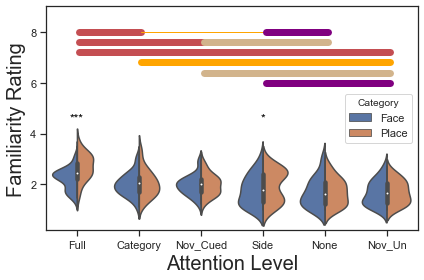

/sustain_2: Average Familiarity by Attention Level


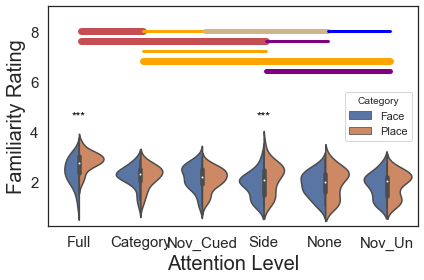

/variabl_1: Average Familiarity by Attention Level
/variabl
Nov_Cued
/variabl
Nov_Un


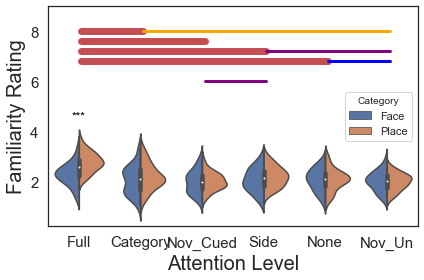

/variabl_2: Average Familiarity by Attention Level
/variabl
Nov_Cued
/variabl
Nov_Un


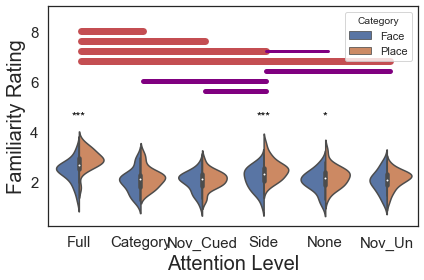

In [21]:
# PLOT PARAMS
snoop = 0
stat_dict_full = {'/sustain_1':{}, '/sustain_2':{}, '/variabl_1':{}, '/variabl_2':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']


# for each experiment, for each test group, group and plot

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + '_' + str(group)
        
        d = data_original[(data_original['Experiment']==experiment)&(data_original['Group']==group)]
        
    
        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures'+experiment + str(group) + 'violin.pdf'
        #plt.savefig(plot_string)
        
        # VIOLIN PLOT
        data = d.groupby(['UniqueID','Attention Level', 'Category'], as_index = False).mean()
        print(label + ': Average Familiarity by Attention Level')
        sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                     data = data, split=True, hue='Category', 
                     order=cats)
        sb_plot.set(ylim=(.2, 9))
        ax1 = sb_plot.axes


        ## SIGNIFICANCE STARS FOR PLOTTING ###
        t_draw = {}

        for c in data['Attention Level'].unique():

            first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
            second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])

        # we want to do a paired t-test between average ratings for Place and Face images attended at each level
        # however, in the variable attention experiment, there may be participants who always had the same last-cued category
        # (because category cues are given in a random order)
        
            if len(first) == len(second):

                # conduct a paired t-test between familiarity ratings for Face and Place images attended at that level
                t = scipy.stats.ttest_rel(first, second)

            elif len(first) != len(second):

                # conduct an independent t-test between familiarity ratings for Face and Place images attended at that level
                t = scipy.stats.ttest_ind(first, second)
                print(experiment)
                print(c)


            if t[1]<.001:
                t_draw[c] = '***'

            elif t[1]<.01:
                t_draw[c] = '**'

            elif t[1]<.05:
                t_draw[c] = '*'

            elif t[1]<.0551:
                t_draw[c] = '+'


        ### SIGNIFICANCE BETWEEN VIOLINS FOR PLOTTING ###
        stat_dict = {}
        k = data.groupby(['UniqueID','Attention Level'],as_index=False).mean()

        for pair in list(itertools.combinations(cats, r=2)):
            t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                                k[k['Attention Level']==pair[1]]['Familiarity Rating'])
            stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

            # dictionary where every key is a pair categories with a difference that has p value less than .0551
            if t[1]<=.0551:
                stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}


        ### CREATE AND ADD SIGNIFICANCE LINES TO PLOT ###
        for relationship in  ['pos','neg']:

            plotted_cats = []
            to_be_plotted = []
            line_height = 0

            # FOR EACH CATEGORY
            for idx,c in enumerate(cats):

                x = sig_bars(c, cats, stat_dict, sign=relationship)
                # get all significance lines from this category to every other category

                for idx,line in enumerate(x):
                # for each line from this category to another category (starting with the nearest category)

                    if (line['categories'] not in plotted_cats) and (line!=np.nan) and (type(line['categories'])!=float):
                    # if there is a difference in the correct direction (pos/neg) and it has not been plotted yet

                        line['y'] = line['y'] + line_height
                        # assign the next available height to this line 
                        # (give its height a boost based on how many lines have been plotted already)

                        to_be_plotted.append(line)
                        # append this line to the list of lines to be plotted

                        plotted_cats.append(line['categories'])
                        # add this category pair to the list of category pairs that has been plotted

                        # CONTINUE THE CASCADE OF LINES
                        # now, start from the category we have just drawn a line to
                        # and loop through the rest of the categories from there

                        # first, give the line a new name so we can loop over new lines, without losing our first one
                        b = line

                        # as long as there is difference in the correct direction (pos/neg) 
                        # between the most recent category and the next one
                        while b['next']!= 0 :

                            # grab the first category for the line between them
                            first_cat = b['categories'][0]

                            # then get the line STARTING from the category we have just drawn a line to, to the NEXT category it differs from
                            b = sig_bars(b['next'], cats, stat_dict, sign=relationship)[0]

                            # if there is a difference in the correct direction (pos/neg) that has not been plotted yet
                            if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):

                                # adjust its height so it is the same height as the line that brought us here
                                b['y'] = b['y'] + line_height

                                # add this line to the lines we will plot
                                to_be_plotted.append(b)

                                # add this category pair to the list of pairs that's been plotted
                                plotted_cats.append(b['categories'])

                                # also add the pair of categories containing the original starting category and this ending category
                                # (so that doesn't get plotted redundantly)
                                plotted_cats.append((line['categories'][0], b['categories'][1]))

                                # AND add the relationship from the original starting category to this starting category
                                # (so that doesn't get plotted redundantly)
                                plotted_cats.append((first_cat, b['categories'][1]))

                        line_height = line_height - .4
                        # adjust height next lines will be drawn at

            # Plot the lines
            for each in to_be_plotted:

                if relationship == 'pos':
                    ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                        linewidth = each['width'], color = col[cats.index(each['categories'][0])])

                if relationship == 'neg':
                    ax1.axhline(each['y']-2, ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                        linewidth = each['width'], color = col[-cats.index(each['categories'][1])])

        # Plot the stars
        for stars in t_draw:
            ax1.text((cats.index(stars)), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')

        # save figure
        
        # plot settings
        sb.set_style("white")
        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Attention Level',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)
        plt.tight_layout()
        


        # show figure
        #plt.legend(bbox_to_anchor=(5.05, 1), loc=2, borderaxespad=0.)
        #plt.legend('',frameon=False)
  
        plt.show()

## Timecourse Plots

In [22]:
def apply_window(combo, window_length):
    '''
    input:  dataframe of behavioral data from an entire experiment
    output: dataframe of same shape where raw values have been replaced by rolling window mean
    '''

    # select data from memory runs
    data = combo[combo['Trial Type']=='Memory'][['Attention Level','Familiarity Rating','Trial','UniqueID','Run']]

    # re-structure the data - each row is a trial, each column is an attn level
    df = data.pivot_table(index=['UniqueID', 'Trial'], columns='Attention Level', values='Familiarity Rating')

    # apply rolling window, for each subject
    window_data = df.groupby(['UniqueID']).apply(lambda x: x.rolling(window_length, min_periods=1, center=True).mean())

    return(window_data)

In [23]:
# combo = data_original[data_original['Group']==2]

# # select data from memory runs
# data = combo[combo['Trial Type']=='Memory'][['Attention Level','Familiarity Rating','Trial','UniqueID','Run']]

# # re-structure the data - each row is a trial, each column is an attn level
# df = data.pivot_table(index=['UniqueID', 'Trial'], columns='Attention Level', values='Familiarity Rating')

# # apply rolling window, for each subject
# window_data = df.groupby(['UniqueID']).apply(lambda x: x.rolling(window_length, min_periods=1, center=True).mean())


In [24]:
plot_data = {}
exp1_mean_window = {'1':[],'2':[]}
exp2_mean_window = {'1':[],'2':[]}


for group in ['2', '1']:
    
    # Apply sliding window
    
    window_length = 20

    exp1_mean_window[group] = apply_window(data_original[(data_original['Experiment']=='/sustain') & (data_original['Group']==int(group))], window_length)
    exp2_mean_window[group] = apply_window(data_original[(data_original['Experiment']=='/variabl') & (data_original['Group']==int(group))], window_length)
    print('finish')
    
    # end up with two dictionaries (one for each exp) each containing two keys ( for groups 1 & 2) 
    
        
for data,label in zip([exp1_mean_window, exp2_mean_window], ['sust', 'var']):

    plot_data[label] = {}

    for key in data.keys():

        # average across all trials within each subject
        group = data[key].reset_index().groupby(['UniqueID','Trial']).mean()

        # melt/restructure the data
        group_melt = pd.melt(group.reset_index(), id_vars=['UniqueID','Trial'], value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])

        # assign data to dictionary key
        plot_data[label][key] = group_melt

    # plotting color key
    palette = sb.color_palette("RdBu", 20)

finish
finish


In [25]:
palette = sb.color_palette("RdBu", 20)

## Sliding Window - Familiarity Over Time

### Sliding Window - Novel Images

sust Group 1: Sliding Window - Novel Images Only


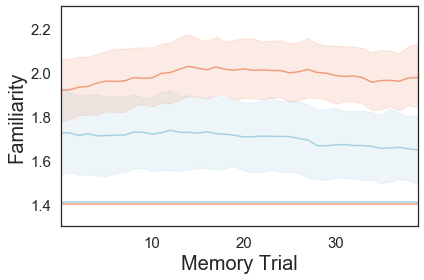

sust Group 2: Sliding Window - Novel Images Only


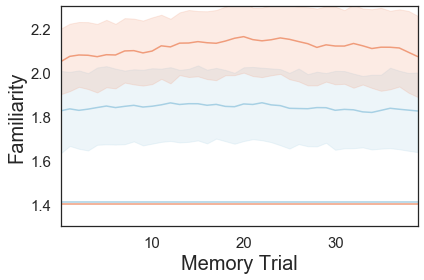

var Group 1: Sliding Window - Novel Images Only


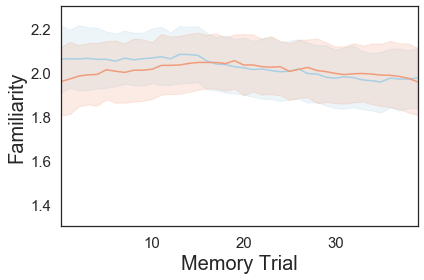

var Group 2: Sliding Window - Novel Images Only


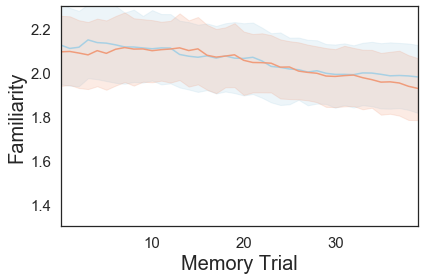

In [26]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        data = plot_data[key][label]

        # plot data
        ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                    data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                                "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
        ax.set(ylim=(1.3, 2.3))
        ax.set(xlim=(0, 39))

        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Attention Level',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)

        plt.xlabel('Memory Trial')
        plt.ylabel('Familiarity')

        # ttest at each timepoint ######################
        ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])

        # add lines where pvalue is significant
        index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

            plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
            # plt.axvline(x, .1, .3, color='red')

        plt.xticks([10, 20, 30])
        plt.tight_layout()
        plt.legend('',frameon=False)
        
        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_novel_window.pdf'
        plt.savefig(plot_string)

        plt.show()    




### Novel Image Difference Scores

sust Group 1: Sliding Window - Novel Images Only
slope = 0.0027412237902213715
intercept = 0.23005042300329384
p_value = 3.2921340018857264e-15



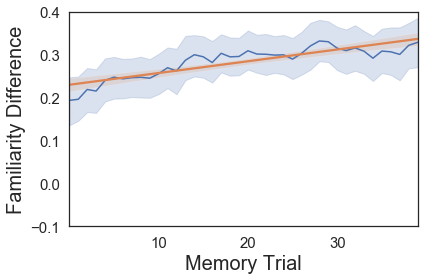

sust Group 2: Sliding Window - Novel Images Only
slope = 0.0013565042167641244
intercept = 0.2480189827171472
p_value = 0.00069299357726985



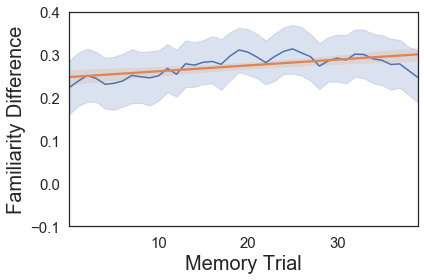

var Group 1: Sliding Window - Novel Images Only
slope = 0.0028318506466567194
intercept = -0.06978233103898906
p_value = 1.2611130878482203e-20



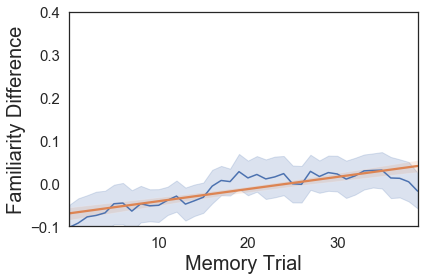

var Group 2: Sliding Window - Novel Images Only
slope = -0.00015312872662007486
intercept = -0.008940984479747012
p_value = 0.5959891699822167



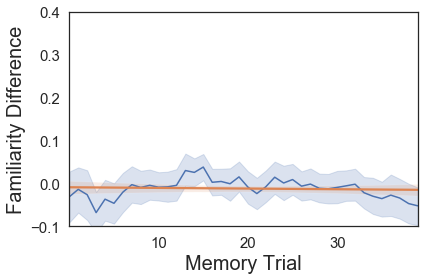

In [27]:

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        # exp = plot_data[key][label]

        trial_avs = plot_data[key][label].groupby(['Trial','Attention Level','UniqueID'], as_index=False).mean()
        trial_avs['Nov_Diffs'] = np.nan

        for s in trial_avs['UniqueID'].unique():
            for t in trial_avs['Trial'].unique():

                first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                                   & (trial_avs['Trial']==t)
                                  & (trial_avs['UniqueID']==s)]['value'].item()
                
                second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                                   & (trial_avs['Trial']==t)
                                  & (trial_avs['UniqueID']==s)]['value'].item()
                
                difference = first - second

                trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['UniqueID']==s),'Nov_Diffs'] = first - second

        ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
        ax.set(ylim=(-.1, .4))
        ax.set(xlim=(0, 39))

        sb.regplot(x="Trial", y="Nov_Diffs", data=trial_avs, scatter=False)

        trial_av_grp = trial_avs.groupby(['Trial'], as_index=False).mean()
        slope, intercept, r_value, p_value, std_err = stats.linregress(trial_avs['Trial'], trial_avs['Nov_Diffs'])

        print('slope = ' + str(slope))
        print('intercept = ' + str(intercept))
        print('p_value = ' + str(p_value))
        print()

        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Attention Level',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)

        plt.xlabel('Memory Trial')
        plt.ylabel('Familiarity Difference')
        plt.xticks([10, 20, 30])
        plt.tight_layout()
        # plt.savefig(exp+"_novel_diff.pdf")

        #print(exp)
        #plt.legend('',frameon=False)
        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_diff.pdf'
        plt.savefig(plot_string)

        plt.show()


### Uncued Category images


In [ ]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        data = plot_data[key][label]
    
        # plot data
        ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                        palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                                "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.legend('',frameon=False)
        ax.set(ylim=(1.2, 2.8))
        ax.set(xlim=(0, 39))


        # stats test
        data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]

        #ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)


        for x in ranges(index):
            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
                plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

            else:
                plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
                plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])


        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Side','None'])

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):
            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
                plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])

            else:
                plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
                plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])

        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
                plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

            else:
                plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
                plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])

                
        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Memory Trial',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)

        plt.xticks([10, 20, 30])
        plt.tight_layout()

        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_uncued_window.pdf'
        plt.savefig(plot_string)

        plt.show()


sust Group 1: Sliding Window - Novel Images Only


### Sliding Window - Images in Cued Category

In [ ]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        data = plot_data[key][label]
    
        # plot ####################################
        ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                    data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                        palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                                "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.legend('',frameon=False)
        ax.set(ylim=(1.25, 3))
        ax.set(xlim=(0, 39))

        #ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)    

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
                plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])


        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Category','Full'])

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
                plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])


            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])


        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
                plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])

        # plot settings & save ####################
        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Memory Trial',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)

        plt.xticks([10, 20, 30])
        plt.tight_layout()

        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_cued_window.pdf'
        plt.savefig(plot_string)


        plt.show()
    

### Images in Cued Location

In [ ]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        data = plot_data[key][label]
    
    
        # plot ####################################
        ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                    data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                        palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                                "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

        ax.set(ylim=(1.25, 3))
        ax.set(xlim=(0, 39))

        #ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)


        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
                plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])

            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])


        # plot settings & save ####################
        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Attention Level',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)
        plt.tight_layout()

        plt.xticks([10, 20, 30])
        plt.legend('',frameon=False)

        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_cued_loc.pdf'
        plt.savefig(plot_string)

        plt.show()
    

### Images in Uncued Location

In [ ]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    for label in ['1','2']:
    
        print(key + ' Group '+ label + ': Sliding Window - Novel Images Only')

        data = plot_data[key][label]
    
        # plot ####################################
        ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                    data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                        palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                                "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set(ylim=(1.25, 3))
        ax.set(xlim=(0, 39))

        #ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)    

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)


        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
                plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])

            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])



        # plot settings & save ####################
        plt.grid(False)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)
        plt.xlabel('Attention Level',    fontsize = 20)
        plt.ylabel('Familiarity Rating', fontsize = 20)

        plt.xticks([10, 20, 30])
        plt.tight_layout()
        plt.legend('',frameon=False)

        plot_string = '/Users/kirstenziman/Documents/github/attention-memory-paper/supp_figures/'+key + label + '_uncued_loc.pdf'
        plt.savefig(plot_string)


        plt.show()
